In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 학습 모델 저장을 위한 라이브러리
import pickle

### 프로젝트 셋팅

In [3]:
# 학습이 완료된 모델을 저장할 파일 이름
best_model_path = 'model/best_model_pitcher_data_3th.dat'

# 예측 결과를 저장할 파일 이름
prediction_path = 'model/pitcher_prediction_3TH.csv'

### 저장한 모델 객체 등을 복원한다.

In [5]:
with open(best_model_path, 'rb') as fp:
    loaded = pickle.load(fp)

# 추출
model = loaded['model']
encoder  = loaded['encoder']
scaler = loaded.get('scaler')

display(model)
display(scaler)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

StandardScaler()

### 예측할 데이터를 준비한다.

In [7]:
X_test = pd.read_csv("X_test.csv")
info_test = pd.read_csv("info_test.csv")
y_test = pd.read_csv("y_test.csv")  

In [8]:
display(X_test.head())
display(info_test.head())
display(y_test.head())

,ERA,FIP,WHIP,SO_x,BB_x,HR_x,H_x,2B_x,3B_x,HP_x,...,W,L,S,HD,pit_G,CG,SHO,GR,GF,WAR
0,4.680,5.570,1.910,85.0,53.5,3.5,60.0,10.5,0.0,4.0,...,12.0,7.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,1.435
1,9.950,7.400,2.470,17.0,18.0,4.0,29.0,4.0,1.0,0.0,...,0.0,4.0,0.0,0.0,10.0,0.0,0.0,5.0,2.0,-0.250
2,3.005,3.495,1.130,158.0,36.5,13.0,174.5,23.0,2.0,9.0,...,21.0,16.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,6.625
3,12.615,7.660,2.155,10.5,10.5,2.0,20.0,5.0,0.0,3.0,...,1.0,3.0,0.0,1.0,30.0,0.0,0.0,28.0,5.0,-0.135
4,5.350,4.165,1.730,10.5,4.0,1.5,14.0,4.5,0.5,0.5,...,1.0,1.0,0.0,6.0,24.0,0.0,0.0,24.0,1.0,-0.040


,pid,선수명
0,14788,이의리
1,14776,한차현
2,15531,후라도
3,13152,최하늘
4,11161,원종현


,연봉등급_인코딩
0,1
1,3
2,0
3,2
4,0


In [9]:
# 데이터 표준화
scaled_data = scaler.transform(X_test)
scaled_data

array([[-0.2652915 , -0.0067599 ,  0.01980701, ..., -0.92934695,
        -0.64978815,  0.64084157],
       [ 0.36041948,  0.61401972,  0.46912765, ..., -0.80779076,
        -0.515282  , -0.75451604],
       [-0.46416548, -0.71064934, -0.60603245, ..., -0.92934695,
        -0.64978815,  4.93870863],
       ...,
       [-0.13824961, -0.18485241, -0.20084152, ..., -0.58898963,
        -0.44802893,  0.03632462],
       [-0.38936512, -0.520684  , -0.47364334, ...,  2.49853747,
         0.4935141 ,  0.61185788],
       [-0.31634572, -0.20859807, -0.34526601, ...,  0.38345985,
         0.08999566, -0.51436547]])

In [10]:
# 입력데이터를 test_X 변수에 담아준다.
test_X = scaled_data

### 예측하고 저장한다.

In [12]:
# 예측한다.
y_pred = model.predict(test_X)
y_pred

array([0, 3, 0, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 3, 1, 3, 0, 3, 3, 3, 3, 1,
       1, 3, 0, 3, 0, 3, 3, 3, 0, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 2, 1, 1,
       2, 3, 3, 3, 0, 1, 0, 1], dtype=int64)

In [13]:
# 예측 결과를 불러온 파일에 저장한다. 
X_test['연봉 등급'] = y_pred

In [14]:
X_test.head()

,ERA,FIP,WHIP,SO_x,BB_x,HR_x,H_x,2B_x,3B_x,HP_x,...,L,S,HD,pit_G,CG,SHO,GR,GF,WAR,연봉 등급
0,4.680,5.570,1.910,85.0,53.5,3.5,60.0,10.5,0.0,4.0,...,7.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,1.435,0
1,9.950,7.400,2.470,17.0,18.0,4.0,29.0,4.0,1.0,0.0,...,4.0,0.0,0.0,10.0,0.0,0.0,5.0,2.0,-0.250,3
2,3.005,3.495,1.130,158.0,36.5,13.0,174.5,23.0,2.0,9.0,...,16.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,6.625,0
3,12.615,7.660,2.155,10.5,10.5,2.0,20.0,5.0,0.0,3.0,...,3.0,0.0,1.0,30.0,0.0,0.0,28.0,5.0,-0.135,3
4,5.350,4.165,1.730,10.5,4.0,1.5,14.0,4.5,0.5,0.5,...,1.0,0.0,6.0,24.0,0.0,0.0,24.0,1.0,-0.040,3


In [59]:
list(X_test.columns)

['ERA',
 'FIP',
 'WHIP',
 'SO_x',
 'BB_x',
 'HR_x',
 'H_x',
 '2B_x',
 '3B_x',
 'HP_x',
 'IB_x',
 'ROE',
 'BK',
 'WP',
 'ER',
 'R_x',
 'TBF',
 'WAR당 연봉',
 'W',
 'L',
 'S',
 'HD',
 'pit_G',
 'CG',
 'SHO',
 'GR',
 'GF',
 'WAR',
 '연봉 등급']

In [15]:
# 예측 결과 인코딩 하기
label_map_rev = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E'
}

# 해당 컬럼을 문자로 매핑
X_test['연봉 등급'] = X_test['연봉 등급'].map(label_map_rev)

# 선수 pid값 붙기기
final_df = pd.concat([info_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

In [16]:
final_df.head()

,pid,선수명,ERA,FIP,WHIP,SO_x,BB_x,HR_x,H_x,2B_x,...,L,S,HD,pit_G,CG,SHO,GR,GF,WAR,연봉 등급
0,14788,이의리,4.680,5.570,1.910,85.0,53.5,3.5,60.0,10.5,...,7.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,1.435,A
1,14776,한차현,9.950,7.400,2.470,17.0,18.0,4.0,29.0,4.0,...,4.0,0.0,0.0,10.0,0.0,0.0,5.0,2.0,-0.250,D
2,15531,후라도,3.005,3.495,1.130,158.0,36.5,13.0,174.5,23.0,...,16.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,6.625,A
3,13152,최하늘,12.615,7.660,2.155,10.5,10.5,2.0,20.0,5.0,...,3.0,0.0,1.0,30.0,0.0,0.0,28.0,5.0,-0.135,D
4,11161,원종현,5.350,4.165,1.730,10.5,4.0,1.5,14.0,4.5,...,1.0,0.0,6.0,24.0,0.0,0.0,24.0,1.0,-0.040,D


In [17]:
# 저장한다 
final_df.to_csv(prediction_path, index=False, encoding='utf-8-sig')
print('저장완료')

저장완료


### 예측 결과 VS 원본 데이터 비교 

In [39]:
# 원본 데이터 불러오기
df_sal = pd.read_csv('선수 연봉 구간 데이터(4구간).csv')
df_pred  = final_df

In [45]:
display(df_sal.head())
display(df_pred.head())

,선수,연봉(만원),WAR,WAR당 연봉,팀,pid,연도,연봉등급
0,류현진,200000.0,2.77,72322,한화 이글스,10590,2025,A
1,폰세,130000.0,5.86,19116,한화 이글스,16313,2025,A
2,플로리얼,97500.0,1.96,50070,한화 이글스,16312,2025,A
3,엄상백,90000.0,-0.11,-783140,한화 이글스,11318,2025,A
4,와이스,84000.0,3.42,24584,한화 이글스,16153,2025,A


,pid,선수명,ERA,FIP,WHIP,SO_x,BB_x,HR_x,H_x,2B_x,...,L,S,HD,pit_G,CG,SHO,GR,GF,WAR,연봉 등급
0,14788,이의리,4.680,5.570,1.910,85.0,53.5,3.5,60.0,10.5,...,7.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,1.435,A
1,14776,한차현,9.950,7.400,2.470,17.0,18.0,4.0,29.0,4.0,...,4.0,0.0,0.0,10.0,0.0,0.0,5.0,2.0,-0.250,D
2,15531,후라도,3.005,3.495,1.130,158.0,36.5,13.0,174.5,23.0,...,16.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,6.625,A
3,13152,최하늘,12.615,7.660,2.155,10.5,10.5,2.0,20.0,5.0,...,3.0,0.0,1.0,30.0,0.0,0.0,28.0,5.0,-0.135,D
4,11161,원종현,5.350,4.165,1.730,10.5,4.0,1.5,14.0,4.5,...,1.0,0.0,6.0,24.0,0.0,0.0,24.0,1.0,-0.040,D


In [47]:
# 1. 필요한 컬럼만 추출해서 merge (불필요한 중복 줄이기)
compare_df = pd.merge(
    df_pred[['pid', '선수명', '연봉 등급']],      # 예측 등급
    df_sal[['pid', '연봉등급']],                 # 실제 등급
    on='pid',
    how='left'
)

# 2. 컬럼명 명확히(선택)
compare_df = compare_df.rename(columns={'연봉 등급': '예측등급', '연봉등급': '실제등급'})

# 3. 결과 확인
display(compare_df.head())

,pid,선수명,예측등급,실제등급
0,14788,이의리,A,B
1,14776,한차현,D,D
2,15531,후라도,A,A
3,13152,최하늘,D,C
4,11161,원종현,D,A


정확도: 0.5961538461538461
F1-score(macro): 0.5023809523809524
              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.50      0.57      0.53        14
           2       0.33      0.09      0.14        11
           3       0.72      0.90      0.80        20

    accuracy                           0.60        52
   macro avg       0.51      0.53      0.50        52
weighted avg       0.55      0.60      0.55        52



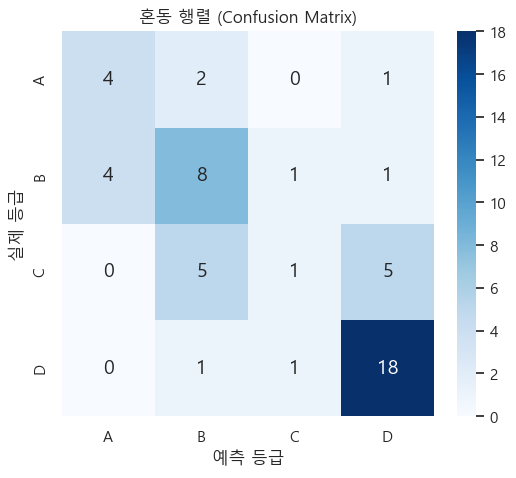

In [53]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 실제, 예측 값 뽑기
y_true = compare_df['실제등급']
y_pred = compare_df['예측등급']

# 필요하다면 인코딩 (문자→숫자)
label_map = {'A':0, 'B':1, 'C':2, 'D':3}
y_true_enc = y_true.map(label_map)
y_pred_enc = y_pred.map(label_map)

print("정확도:", accuracy_score(y_true_enc, y_pred_enc))
print("F1-score(macro):", f1_score(y_true_enc, y_pred_enc, average='macro'))
print(classification_report(y_true_enc, y_pred_enc))

cm = confusion_matrix(y_true_enc, y_pred_enc)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("예측 등급")
plt.ylabel("실제 등급")
plt.title("혼동 행렬 (Confusion Matrix)")
plt.show()